In [18]:
import generate_network, importlib
importlib.reload(generate_network)
from generate_network import *
import os

import numpy as np

N = 50000
L = 5
n0 = 500
n_sets = 10
k_min = 5
k_max = 50
t_k = -2.0
theta = 1.0


churn_vals = [round(x, 1) for x in np.arange(0.1, 0.9, 0.1)]
p_stay_values = [round(x, 1) for x in np.arange(0.1, 0.9, 0.1)]
mu_vals = [round(x, 2) for x in np.arange(0.1, 0.4, 0.05)]
os.makedirs("sync_data", exist_ok=True)

def fmt_decimal(val: float):
    s = f"{val:.2f}"
    whole, frac = s.split(".")
    return f"{whole}{frac.zfill(2)}"

for churn in churn_vals:
    for p_stay in p_stay_values:
        for mu in mu_vals:    
            join_rate = churn
            leaving_rate = churn
            churn_tag = fmt_decimal(churn)
            p_stay_tag = fmt_decimal(p_stay)
            mu_tag = fmt_decimal(mu)
            filename = f"change-churn{churn_tag}-p{p_stay_tag}-mu{mu_tag}.csv"
            output_path = os.path.join("sync_data/change", filename)

            print(f"Generating {output_path} (p_stay={p_stay})")

            generate_multilayer_network(
                node_pool=N,
                layer=L,
                init_size=n0, 
                n_sets=n_sets,
                mu=mu,
                k_min=k_min,
                k_max=k_max,
                t_k=t_k,
                theta=theta,
                p_stay=p_stay,
                join_rate=join_rate,
                leaving_rate=leaving_rate,
                output_path=output_path
            )

Generating sync_data/change/change-churn010-p010-mu010.csv (p_stay=0.1)
[{'layer': 0, 'size': 500, 'survivors': 500, 'entrants': 500, 'jaccard_with_prev': 1.0}, {'layer': 1, 'size': 519, 'survivors': 455, 'entrants': 64, 'jaccard_with_prev': 0.8067375886524822}, {'layer': 2, 'size': 513, 'survivors': 464, 'entrants': 49, 'jaccard_with_prev': 0.8169014084507042}, {'layer': 3, 'size': 520, 'survivors': 459, 'entrants': 61, 'jaccard_with_prev': 0.7996515679442509}, {'layer': 4, 'size': 505, 'survivors': 460, 'entrants': 45, 'jaccard_with_prev': 0.8141592920353983}]
Generating sync_data/change/change-churn010-p010-mu015.csv (p_stay=0.1)
[{'layer': 0, 'size': 500, 'survivors': 500, 'entrants': 500, 'jaccard_with_prev': 1.0}, {'layer': 1, 'size': 519, 'survivors': 455, 'entrants': 64, 'jaccard_with_prev': 0.8067375886524822}, {'layer': 2, 'size': 513, 'survivors': 464, 'entrants': 49, 'jaccard_with_prev': 0.8169014084507042}, {'layer': 3, 'size': 520, 'survivors': 459, 'entrants': 61, 'jacca

In [19]:
import re

def parse_filename(path: str):
    fname = os.path.basename(path)
    m = re.match(r"change-churn(\d+)-p(\d+)-mu(\d+)\.csv", fname)
    if not m:
        raise ValueError(f"cannot parse file name: {fname}")
    
    churn_tag = m.group(1)
    pstay_tag = m.group(2) 
    mu_tag = m.group(3)

    def tag_to_float(tag: str) -> float:
        # 例如 '01' -> 0.1, '015' -> 0.15
        if len(tag) == 1:
            return float(f"0.{tag}")
        else:
            return float(tag[0] + "." + tag[1:])

    churn_val = tag_to_float(churn_tag)
    p_stay_val = tag_to_float(pstay_tag)
    mu_val = tag_to_float(mu_tag)
    return churn_val, p_stay_val, mu_val

print(parse_filename("sync_data/change/change-churn020-p050-mu020.csv"))

(0.2, 0.5, 0.2)


In [ ]:
import algorithms, measurement, importlib
importlib.reload(algorithms)
importlib.reload(measurement)
from algorithms import *
from measurement import *

import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_filename(path: str):

    fname = os.path.basename(path)
    m = re.match(r"change-churn(\d+)-p(\d+)-mu(\d+)\.csv", fname)
    if not m:
        raise ValueError(f"cannot parse file name: {fname}")
    churn_tag = m.group(1)
    pstay_tag = m.group(2) 
    mu_tag = m.group(3)
    def tag_to_float(tag: str) -> float:
        # 例如 '01' -> 0.1, '015' -> 0.15
        if len(tag) == 1:
            return float(f"0.{tag}")
        else:
            return float(tag[0] + "." + tag[1:])

    churn_val = tag_to_float(churn_tag)
    p_stay_val = tag_to_float(pstay_tag)
    mu_val = tag_to_float(mu_tag)
    return churn_val, p_stay_val, mu_val

relax_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
csv_files = glob.glob("sync_data/change/change-churn*-p*.csv")

records = []

for file_path in csv_files:
    churn_val, p_stay_val, mu_val = parse_filename(file_path)
    print(f"\nProcessing file: {file_path}  (churn={churn_val}, p_stay={p_stay_val}), mu={mu_val}")

    for rate in relax_rates:
        try:
            partition = infomap_communities(file_path, None, jsd_relax_rate=rate)
            mami = compute_layerwise_ami_avg(file_path, partition)

            records.append({
                "churn": churn_val,
                "p_stay": p_stay_val,
                "mu": mu_val,
                "relax_rate": rate,
                "mami": mami,
                "file": os.path.basename(file_path),
            })

        except Exception as e:
            print(f"Error: {e}")


infomap_df = pd.DataFrame(records)


/var/folders/6r/8pf7t78x2jz69wslwjn4r2sc0000gn/T/ipykernel_20534/3486719754.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


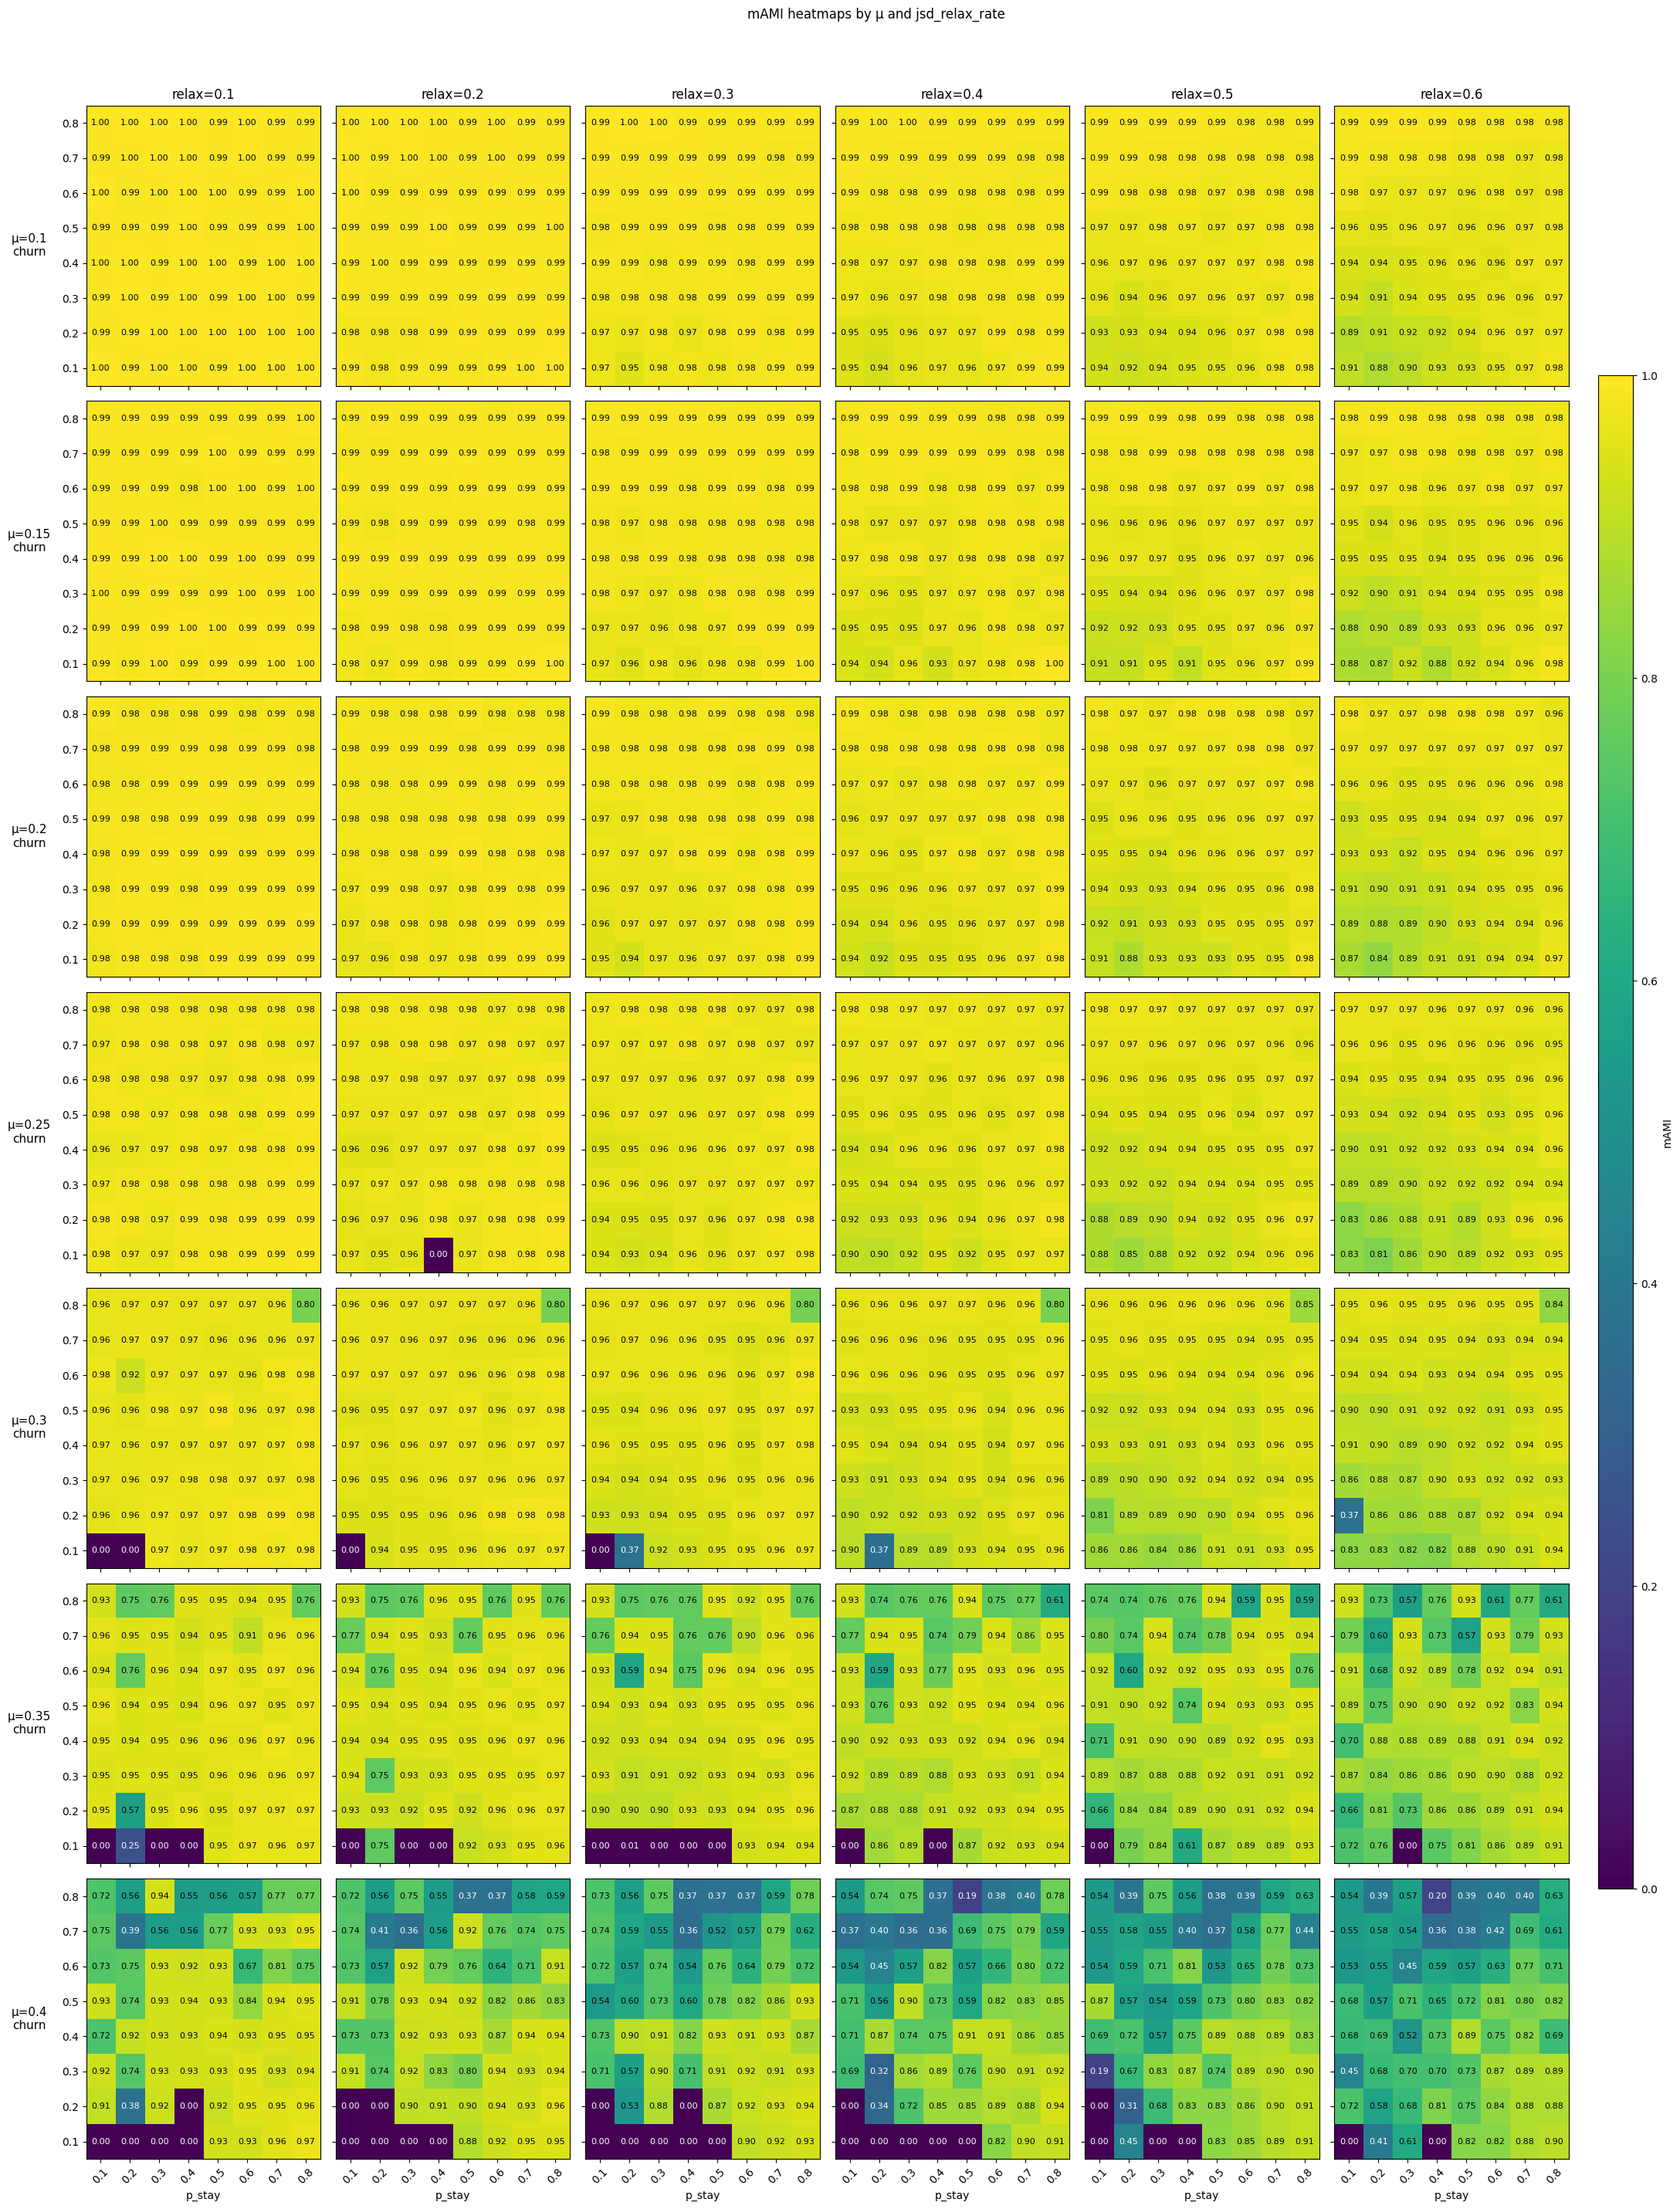

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 聚合数据 ===
infomap_heat_df = (
    infomap_df
    .groupby(["mu", "relax_rate", "churn", "p_stay"], as_index=False)["mami"]
    .mean()
)

relax_rates_unique = sorted(infomap_heat_df["relax_rate"].unique())
churn_unique = sorted(infomap_heat_df["churn"].unique())
p_stay_unique = sorted(infomap_heat_df["p_stay"].unique())
mu_unique = sorted([m for m in infomap_heat_df["mu"].unique() if pd.notna(m)])

n_rates = len(relax_rates_unique)
n_mu = len(mu_unique)

# === 子图布局 ===
fig, axes = plt.subplots(
    n_mu, n_rates,
    figsize=(3.8 * n_rates, 4 * n_mu),
    sharex=True, sharey=True
)

# 统一二维索引
if n_mu == 1:
    axes = np.array([axes])
if n_rates == 1:
    axes = axes[:, np.newaxis]

vmin = infomap_heat_df["mami"].min()
vmax = infomap_heat_df["mami"].max()

# === 绘图循环 ===
for i_mu, mu_val in enumerate(mu_unique):
    for j_rate, rrate in enumerate(relax_rates_unique):
        ax = axes[i_mu, j_rate]

        sub = infomap_heat_df[
            (infomap_heat_df["mu"] == mu_val)
            & (infomap_heat_df["relax_rate"] == rrate)
        ]
        pivot_mat = sub.pivot(index="churn", columns="p_stay", values="mami")
        pivot_mat = pivot_mat.reindex(index=churn_unique, columns=p_stay_unique)

        im = ax.imshow(
            pivot_mat.values,
            aspect="auto",
            origin="lower",
            vmin=vmin,
            vmax=vmax,
            cmap="viridis"
        )

        # 坐标刻度
        ax.set_xticks(range(len(p_stay_unique)))
        ax.set_xticklabels([str(v) for v in p_stay_unique], rotation=45)
        ax.set_yticks(range(len(churn_unique)))
        ax.set_yticklabels([str(v) for v in churn_unique])

        if i_mu == n_mu - 1:
            ax.set_xlabel("p_stay")
        if j_rate == 0:
            ax.set_ylabel("churn")

        if i_mu == 0:
            ax.set_title(f"relax={rrate}")

        # 数值标注
        for i_churn, churn_val in enumerate(churn_unique):
            for j_p, pstay_val in enumerate(p_stay_unique):
                val = pivot_mat.loc[churn_val, pstay_val]
                if pd.notna(val):
                    text_color = "white" if val < (vmin + vmax) / 2 else "black"
                    ax.text(
                        j_p, i_churn,
                        f"{val:.2f}",
                        ha="center",
                        va="center",
                        fontsize=8,
                        color=text_color
                    )

    # 每行最左侧显示 mu 值标签
    axes[i_mu, 0].set_ylabel(f"μ={mu_val}\nchurn", fontsize=11, rotation=0, labelpad=30, va="center")

# === 统一颜色条 ===
fig.subplots_adjust(right=0.88, wspace=0.2, hspace=0.25)
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("mAMI")

plt.suptitle("mAMI heatmaps by μ and jsd_relax_rate", y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# GW coupling

In [38]:
import algorithms, measurement, importlib
importlib.reload(algorithms)
importlib.reload(measurement)
from algorithms import *
from measurement import *

result_df, _, A_supra, B = hetero_genlouvain_communities(
    csv_path="sync_data/change/change-churn010-p010-mu010.csv",
    omega_scale=500.0,
    metric="cosine",
    node2vec_dim=32,
    seed=42,
)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [46]:
from measurement import *

hetero_ami = compute_layerwise_ami_avg("sync_data/change/change-churn010-p010-mu010.csv",result_df)

[0.9713264342087403, 0.9565537377421252, 0.9957209581890321, 0.9684686047752156, 0.9394902120737555]


In [47]:
print(hetero_ami)

0.9663119893977736
